# Lecture 03 - Geocentric Models

In [13]:
import sys, os
sys.path.append(os.path.abspath("../src"))  # make src importable

# Project modules
import init_notebook
import utils

# Third-party libs – explicit per notebook
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from scipy import stats
import xarray as xr

# Run the setup
init_notebook.setup()

Using style file: /Users/gharda/Documents/Code/statistical-rethinking-pymc/statistical-rethinking-pymc.mplstyle
Module aliases imported by init_notebook.py:
--------------------------------------------
import np
import pd
import smf
import pm
import xr
import az
import stats
import plt
import utils
Watermark:
----------
Last updated: 2025-12-06T11:29:32.279346+07:00

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 9.7.0

Compiler    : Clang 17.0.0 (clang-1700.3.19.1)
OS          : Darwin
Release     : 25.1.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

scipy      : 1.16.3
pymc       : 5.26.1
pytensor   : 2.35.1
statsmodels: 0.14.5
watermark  : 2.5.0
arviz      : 0.22.0
pandas     : 2.3.3
matplotlib : 3.10.7
xarray     : 2025.11.0
numpy      : 2.3.5
pathlib    : 1.0.1



## Linear Regression
- Geocentric
    - unreasonably good approximations, despite it always being incorrect
    - can be used as a cog in causal analysis system, despite being an inaccurate mechanistic model of real phenomena
- Gaussian
    - General error model
    - Abstracts away details, allowing us to make macro inferences, without having to incorporate micro phenomena

## Why Normal?
### Two arguments
1. Generative: summed fluctuations tend toward Normal distribution (see below)
2. Inferential: For estimating mean and variance, the Normal is the least informative (fewest assumptions), in the maximum entropy sense

> Variables do not need to be Normally-distributed in order to estimate the correct mean and variance using a Gaussian error model.

### Generating Normal distribution from summation of decisions
- Simulate a group of people randomly walking left-right, starting from a central location
- Resulting positions are the summation of many lef-and right deviations -- the result is Normally-distributed
- Normal distribution falls out of processes where deviations are summed (also products)

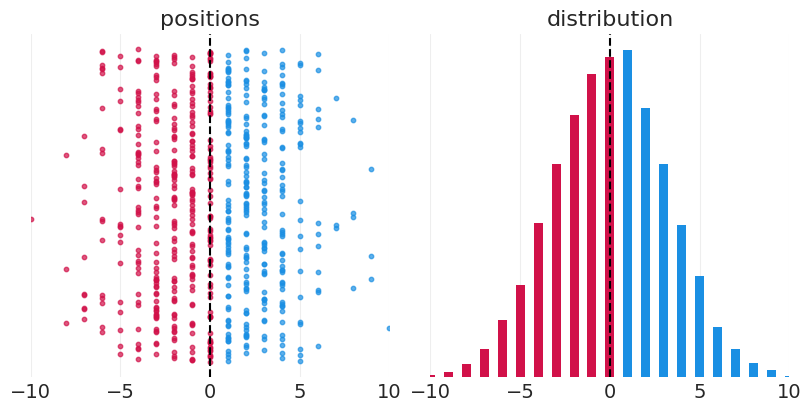

In [2]:
n_people = 10000
n_steps = 1000

step_size = .1
left_right_step_decisions = (2 * stats.bernoulli(p=.5).rvs(size=(n_people, n_steps)) - 1)
steps = step_size * left_right_step_decisions

positions = np.round(np.sum(steps, axis = 1))
fig, axs = plt.subplots(1, 2, figsize = (8, 4))

plt.sca(axs[0])
plt.axvline(0, color = 'k', linestyle = '--')
for ii, pos in enumerate(positions[::15]):
    color = 'C1' if pos > 0 else 'C0'
    plt.scatter(x = pos, y = ii, color = color, alpha = .7, s = 10)
    
plt.xlim([-10, 10])
plt.yticks([])
plt.title("positions")

# Plot histogram
position_unique, position_counts = np.unique(positions, return_counts = True)
positive_idx = position_unique > 0
negative_idx = position_unique <= 0 
plt.sca(axs[1])
plt.bar(position_unique[positive_idx], position_counts[positive_idx], width = .5, color = 'C1')
plt.bar(position_unique[negative_idx], position_counts[negative_idx], width = .5, color = 'C0')
plt.axvline(0, color = 'k', linestyle = '--')
plt.xlim([-10, 10])
plt.yticks([])
plt.title("distribution");

## Drawing the Owl
1. State clear question -- establish an estimand
2. Sketch causal assumptions -- draw the DAG
3. Define a generative model based on causal assumptions -- generate synthetic data
4. Use generative model to build (AND TEST) an estimator -- can we recover the data-generating parameters of (3)?
5. Profit: through analyzing real data (possibly gaining insights to iterate on assumptions, model, and/or estimator)

## Linear Regression

### Howell Dataset

#### (1) Question & Estimand
- Describe the association between weight and height
- We'll focus on adult weight -- Adult height is approximately linear

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


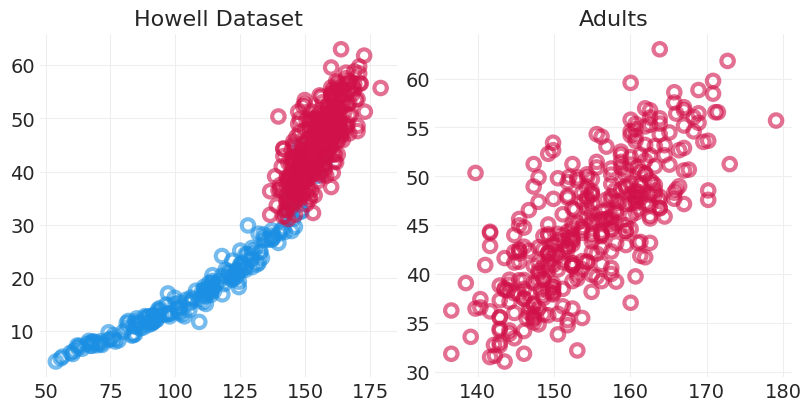

In [3]:
HOWELL = utils.load_data("Howell1")
fig, axs = plt.subplots(1, 2, figsize = (8, 4))

ADULTS = HOWELL.age >= 18
ADULT_HOWELL = HOWELL[ADULTS]
CHILD_HOWELL = HOWELL[~ADULTS]

plt.sca(axs[0])
utils.plot_scatter(CHILD_HOWELL.height, CHILD_HOWELL.weight, color = 'C1')
utils.plot_scatter(ADULT_HOWELL.height, ADULT_HOWELL.weight)
plt.title("Howell Dataset")

plt.sca(axs[1])
utils.plot_scatter(ADULT_HOWELL.height, ADULT_HOWELL.weight)
plt.title("Adults")
HOWELL.head()

In [4]:
from utils import DATA_DIR, load_data
print(DATA_DIR)              # confirm path
print(DATA_DIR.exists())     # should be True
print((DATA_DIR / "Howell1.csv").exists())  # should be True

HOWELL = load_data("Howell1")
HOWELL.head()

/Users/gharda/Documents/Code/statistical-rethinking-pymc/data
True
True


,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


#### (2) Scientific Model
How does **height** influence **weight**?

$$
\begin{align}
    H & \rightarrow W \\
    W & = f(H)
\end{align}
$$

i.e. *"Weight is some function of height"*

#### (3) Generative Models
Options
1. Dynamic - relationship changes over time
2. Statis - constant trend over time

$$ W =  f(H, U) $$

*"Weight $W$ is a function of height, $H$ and some unobserved stuff, $U$"*

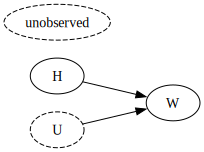

In [5]:
utils.draw_causal_graph(
    edge_list=[
        ("H", "W"),
        ("U", "W")
    ],
    node_props={
        "U": {"style": "dashed"},
        "unobserved": {"style": "dashed"}
    },
    graph_direction="LR"
)

##### Linear regression model
We need a function that maps adult weight as a proportion of height plus some unobserved/unaccounted-for causes. Enter **Linear Regression**:

$$ W = \beta H + U $$

##### Generative model description:

$$
\begin{align}
    W_i & \sim \beta H_i + U_i \\
    U_i & \sim \text{Normal}(0, 10) \\
    H_i & \sim \text{Uniform}(130, 170)
\end{align}
$$

##### Describing models

- Variables on the left
- Definition on right
- $\sim$ indicates sampling from a distribution
    - e.g. $H \sim \text{Uniform}(130, 170)$ is definition that *height is distributed uniformly between 130 and 170*
- $=$ indicates statistical expectation or deterministic equality
    - e.g. $W \sim \beta H + U $ is definition of equation for *expected weight*
- subscripts $i$ indicates index of a observation/individual
- generally code will be written in opposite direction, because you need variables defined in order to be referenced/composed

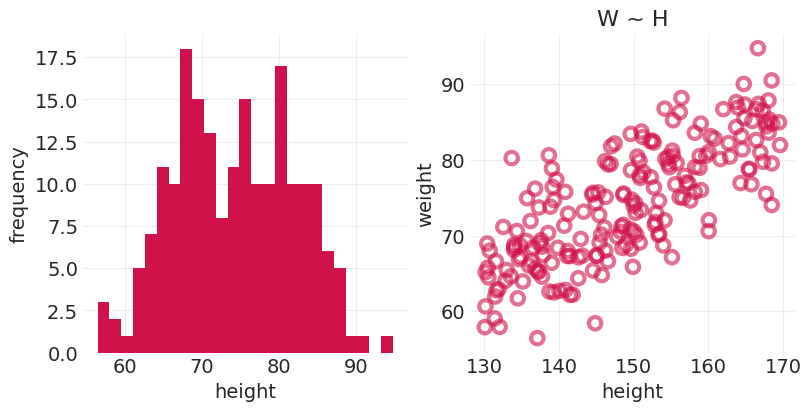

In [6]:
def simulate_weight(H: np.array, beta: float, sigma: float) -> np.ndarray:
    """
    Generative model describe above, simulate weight given height, `H`,
    proportional coefficient `beta`, and the standard deviation of
    unobserved (Normally-distributed) noise, sigma.
    """
    n_heights = len(H)
    
    # unobserved noise
    U = stats.norm.rvs(0, sigma, size = n_heights)
    return beta * H + U

n_heights = 200
MIN_HEIGHT = 130
MAX_HEIGHT = 170
H = stats.uniform.rvs(MIN_HEIGHT, MAX_HEIGHT - MIN_HEIGHT, size = n_heights)
W = simulate_weight(H, beta = 0.5, sigma = 5)

fig, axs = plt.subplots(1, 2, figsize = (8, 4))

plt.sca(axs[0])
plt.hist(W, bins = 25)
plt.xlabel("height")
plt.ylabel("frequency")

plt.sca(axs[1])
utils.plot_scatter(H, W)
plt.title("W ~ H")
plt.xlabel("height")
plt.ylabel("weight");

##### Linear Regression
Estimate how the averate weight changes with a change in height:

$$
E[W_i|H_i] = \alpha + \beta H_i
$$

- $E[W_i|H_i]$: **average weight** conditioned on height
- $\alpha$: **intercept** of line
- $\beta$: **slope** of line

##### Posterior Distribution
$$
p(\alpha, \beta, \sigma) = \frac{p(W_i|\alpha, \beta, \sigma)p(\alpha, \beta, \sigma)}{Z}
$$

- The only estimator in Bayesian data analysis
- $p(\alpha, \beta, \sigma)$ -- **Posterior**: Probability of a specific line (model)
- $p(W|i|\alpha, \beta, \sigma)$ -- **Likelihood**: The number of ways the generative process (line) could have produced the data
    - aka the "Garden of Forking Data" from Lecture 2
- $p(\alpha, \beta, \sigma)$ -- **Prior**: the previous Posterior (sometimes with no data)
- $Z$ -- **Normalization constant**: ensures the Posterior sums to 1 over all possible models

Common parameterization
$$
W_i \sim \text{Normal}(\mu_i, \sigma) \\
\mu_i = \alpha + \beta H_i
$$

*$W$ is distributed normally with mean $\mu$ that is a linear function of $H$*

##### Grid Approximate Posterior
For the following grid approximation simulation, we'll use a utility function `utils.simulate_2_parameter_bayesian_learning_grid_approximation` for simulating general Bayesian posterior update simulation. For the API, see `utils.py`

In [7]:
help(utils.simulate_2_parameter_bayesian_learning_grid_approximation)

Help on function simulate_2_parameter_bayesian_learning_grid_approximation in module utils:

simulate_2_parameter_bayesian_learning_grid_approximation(x_obs, y_obs, param_a_grid, param_b_grid, true_param_a, true_param_b, model_func: 'Callable', posterior_func: 'Callable', n_posterior_samples: 'int' = 3, param_labels=None, data_range_x=None, data_range_y=None)
    Simulate Bayesian learning in a 2-parameter model using grid approximation.



Function for `simulate_2_parameter_bayesian_learning`

In [8]:
# Model function required for simulation
def linear_model(x: np.ndarray, intercept: float, slope: float) -> np.ndarray:
    return intercept + slope * x

# Posterior function required for simulation
def linear_regression_posterior(
    x_obs: np.ndarray,
    y_obs: np.ndarray,
    intercept_grid: np.ndarray,
    slope_grid: np.ndarray,
    likelihood_prior_std: float = 1.0
) -> np.ndarray:
    
    # Convert params to 1-d arrays
    if np.ndim(intercept_grid) > 1:
        intercept_grid = intercept_grid.ravel()
        
    if np.ndim(slope_grid):
        slope_grid = slope_grid.ravel()
    
    log_prior_intercept = stats.norm(0, 1).logpdf(intercept_grid)
    log_prior_slope = stats.norm(0, 1).logpdf(slope_grid)
    
    log_likelihood = np.array(
        [
            stats.norm(
                intercept + slope * x_obs,
                likelihood_prior_std
            ).logpdf(y_obs) for intercept, slope in zip(intercept_grid, slope_grid)
        ]
    ).sum(axis=1)
    
    # Posterior is equal to the product of likelihood and priors (here a sum in log scale)
    log_posterior = log_likelihood + log_prior_intercept + log_prior_slope

    # Convert back to natural scale
    return np.exp(log_posterior - log_posterior.max())

##### Simulating Posterior Updates

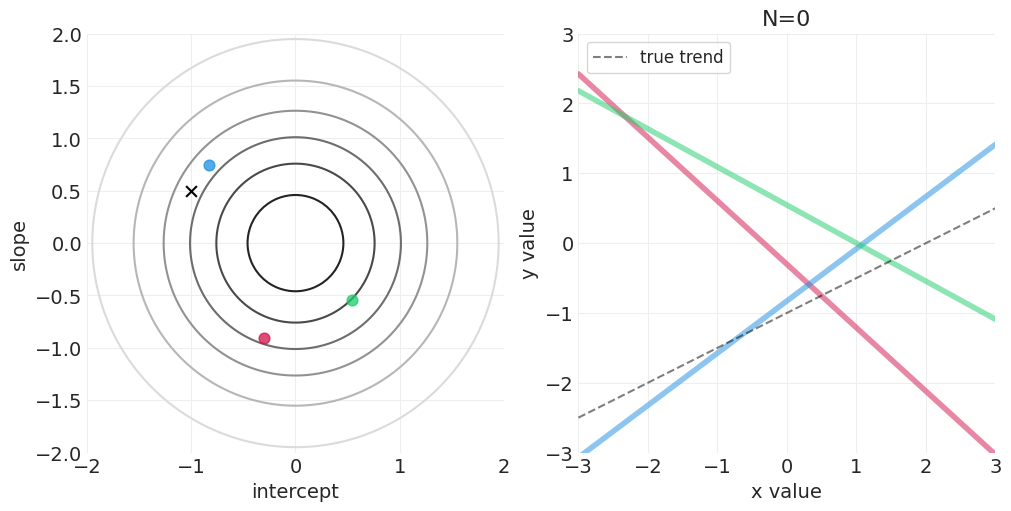

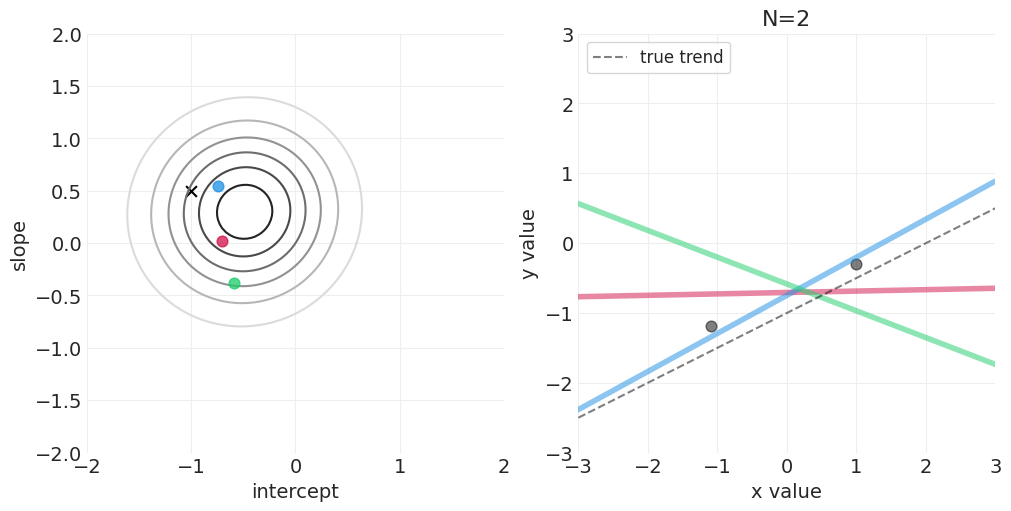

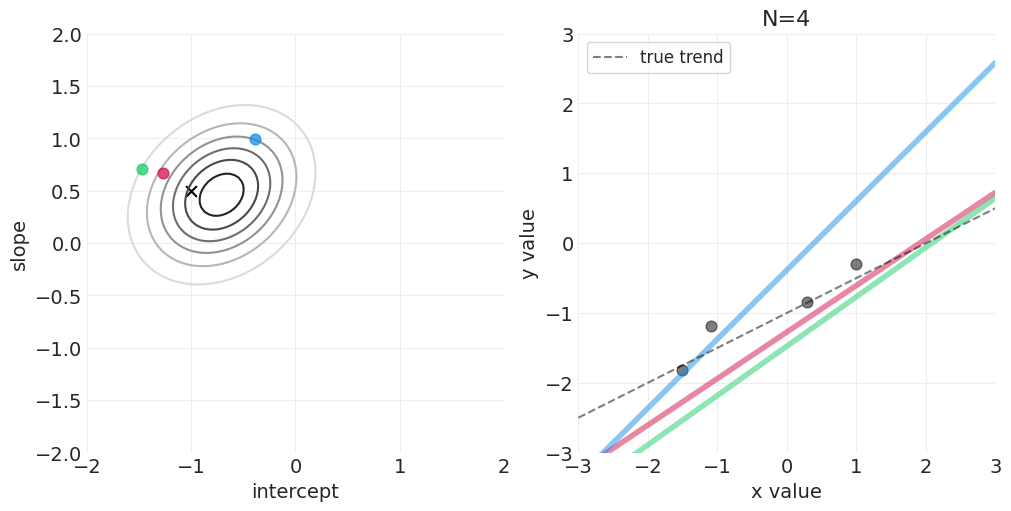

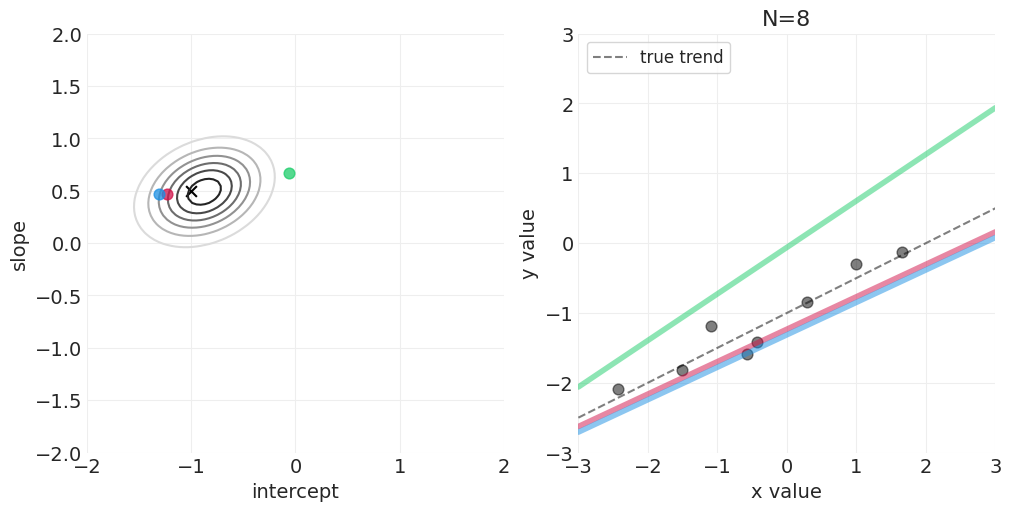

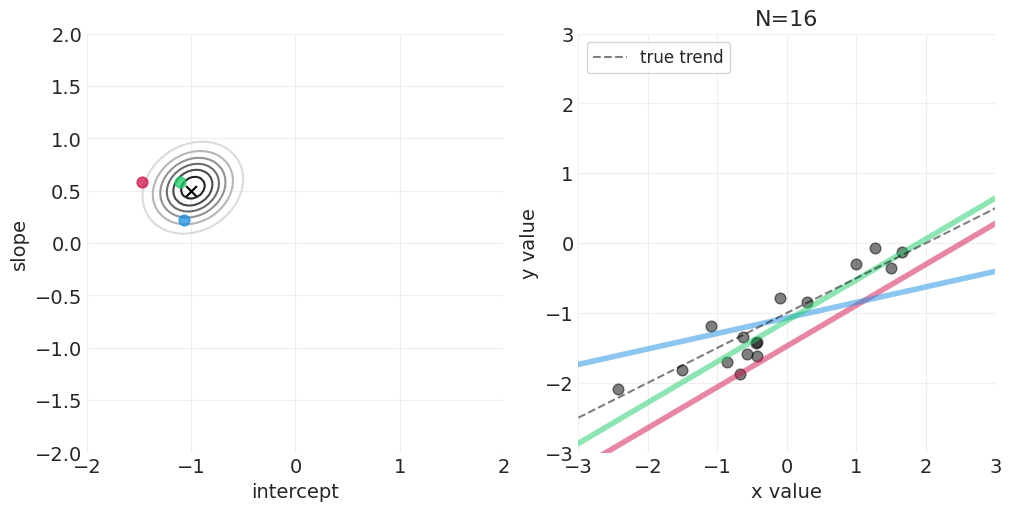

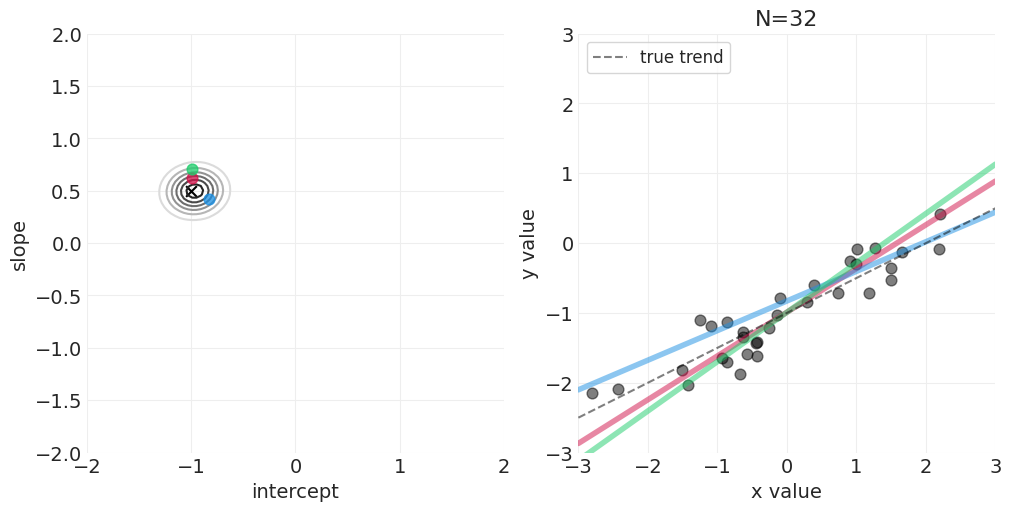

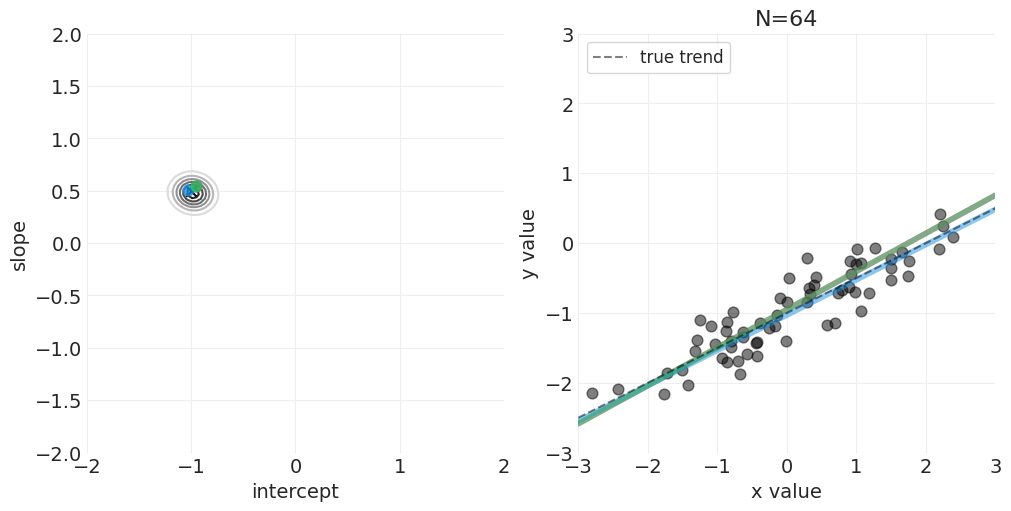

In [9]:
# Generate standardized regression data for demo
np.random.seed(123)
RESOLUTION = 100
N_DATA_POINTS = 64

# Ground truth parameters
SLOPE = 0.5
INTERCEPT = -1

x = stats.norm.rvs(size = N_DATA_POINTS)
y = INTERCEPT + SLOPE * x + stats.norm.rvs(0, 1, size = N_DATA_POINTS) * 0.25

slope_grid = np.linspace(-2, 2, RESOLUTION)
intercept_grid = np.linspace(-2, 2, RESOLUTION)

# Vary the sample size to show how the posterior adapts to more and more data
for n_samples in [0, 2, 4, 8, 16, 32, 64]:
    # Run the simulation
    utils.simulate_2_parameter_bayesian_learning_grid_approximation(
        x_obs = x[:n_samples],
        y_obs = y[:n_samples],
        param_a_grid = intercept_grid,
        param_b_grid = slope_grid,
        true_param_a = INTERCEPT,
        true_param_b = SLOPE,
        model_func = linear_model,
        posterior_func = linear_regression_posterior,
        param_labels = ["intercept", "slope"],
        data_range_x = (-3, 3),
        data_range_y = (-3, 3)
    )

##### Enough Grid Approximation -- `quap` vs `MCMC` implementations

McElreath uses Quadratic Approximation--`quap`--for the first half of the lectures, which *can* speed up model fitting for continuous models that have posteriors that can be approximated with a multi-dimensional Normal distribution. However, we'll just use PyMC MCMC implementations for all examples without loss of generality. For the earlier examples in the lecture series where quap is being used, MCMC samples perfectly fast anyways.

#### (4) Validate the model

##### Validate Assumptions with **Prior Predictive Distribution**

- Priors should express scientific knowledge, but softly
- For example, when Height is 0, Weight should be 0, right?
- Weight should increase (on average) with height -- i.e. $\beta > 0$
- Weight (kg) should be less than Height (cm)
- variances should be positive

$$
\begin{align}
    \alpha & \sim \text{Normal}(0, 10) \\
    \beta & \sim \text{Normal}(0, 1) \\
    \sigma & \sim \text{Exponential}(1)
\end{align}
$$

##### More on Priors

- We can understand the implications of priors by running simulations
- **There are no correct priors**, only those that are scientifically justifiable
- Priors are less important with simple models
- **Priors are very important in complex models**

(30.0, 70.0)

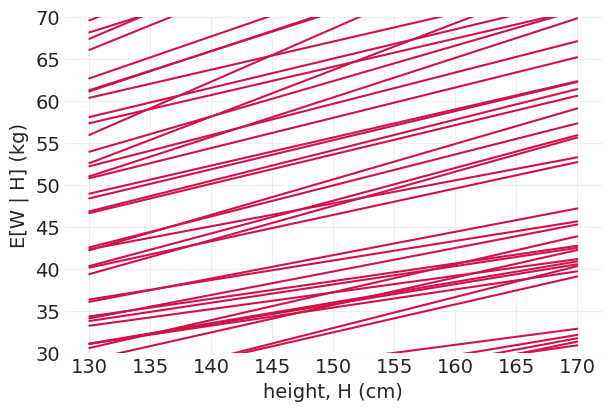

In [10]:
n_simulations = 100

alphas = np.random.normal(0, 10, n_simulations)
betas = np.random.uniform(0, 1, n_simulations) # beta should all be positive

heights = np.linspace(130, 170, 3)

fig, ax = plt.subplots(figsize = (6, 4))
for a, b in zip(alphas, betas):
    weights = a + b * heights
    plt.plot(heights, weights, color = 'C0')
    
plt.xlabel("height, H (cm)")
plt.ylabel("E[W | H] (kg)")
plt.ylim((30, 70))

##### Simulation-based Validation & Calibration

- Simulate data with varying parameters
- Vary data-generating parameters (e.g. slope) that are analogous to the model; make sure the estimator tracks
- Make sure that at large sample sizes, data-generating parameters can be recovered
- Same for confounds/unkowns

In [11]:
linear_regression_inferences = []
linear_regression_models = []

sample_sizes = [1, 2, 10, 20, 50, len(H)]

for sample_size in sample_sizes:
    print(f"Sample size: {sample_size}")
    
    with pm.Model() as model:
        
        # Mutable data for posterior predictive visualization
        H_ = pm.Data("H", H[:sample_size], dims = "obs_id")
        
        # Priors
        alpha = pm.Normal("alpha", 0, 10) # Intercept
        beta = pm.Uniform("beta", 0, 1) # slope
        sigma = pm.Uniform("sigma", 0, 10) # noise variance
        
        # Likelihood
        mu = alpha + beta * H_
        pm.Normal("W_obs", mu, sigma, observed = W[:sample_size], dims = "obs_id")
        
        # Sample posterios
        inference = pm.sample(target_accept = .99)
        linear_regression_inferences.append(inference)
        linear_regression_models.append(model)

Initializing NUTS using jitter+adapt_diag...


Sample size: 1


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
Initializing NUTS using jitter+adapt_diag...


Sample size: 2


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
Initializing NUTS using jitter+adapt_diag...


Sample size: 10


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Initializing NUTS using jitter+adapt_diag...


Sample size: 20


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Initializing NUTS using jitter+adapt_diag...


Sample size: 50


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Initializing NUTS using jitter+adapt_diag...


Sample size: 200


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


##### Test Model Validity with Posterior Predictive Distribution

Below we show:

- how the posterior becomes more specific with more of observations
- how the posterior is "made of lines" -- there are an infinite number of possible lines that can be drawn from the posterior
- confidence intervals can be established to communicate the uncertainty of the posterior's fit to the data

Sampling: [W_obs]
Sampling: [W_obs]


Sample size 1
Sample size 2


Sampling: [W_obs]
Sampling: [W_obs]
Sampling: [W_obs]


Sample size 10
Sample size 20
Sample size 50


Sampling: [W_obs]


Sample size 200


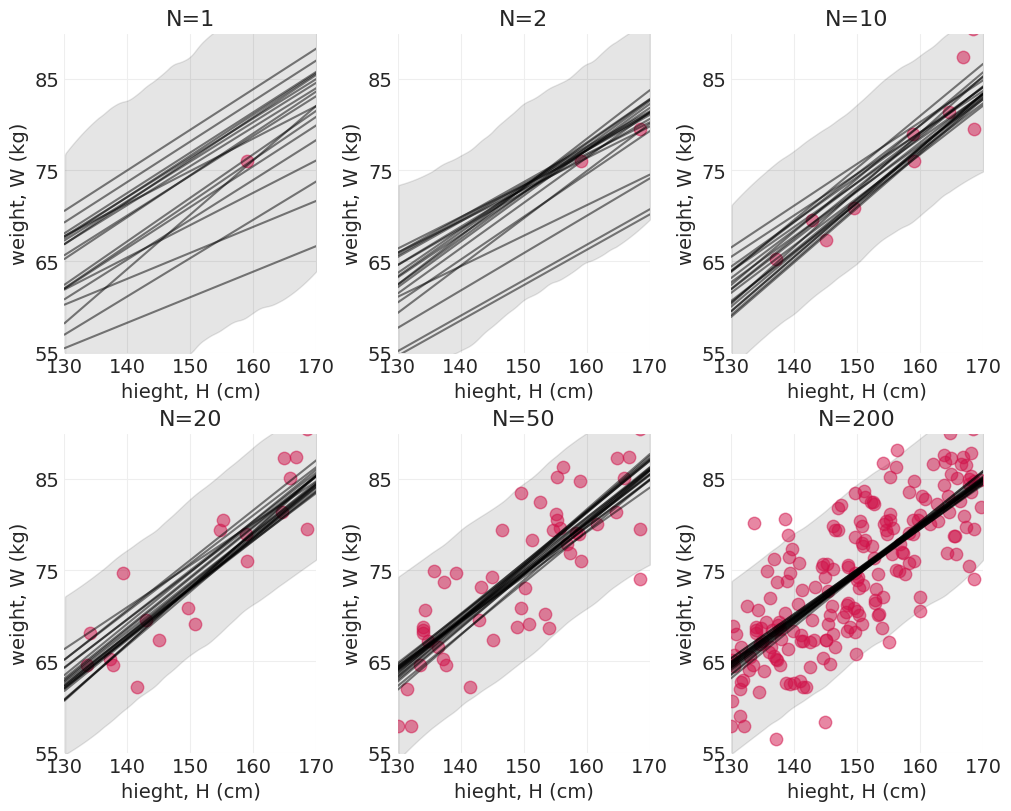

In [14]:
N_SHOW = 20
MIN_WEIGHT = 55
MAX_WEIGHT = 90

def plot_linear_regression_posterior_predictive(
    model, inference,
    min_height = MIN_HEIGHT,
    max_height = MAX_HEIGHT,
    min_weight = MIN_WEIGHT,
    max_weight = MAX_WEIGHT,
    N_SHOW = 20
):
    xs = np.linspace(min_height, max_height, 30)
    H_ = xr.DataArray(xs)
    
    # Sample Posterior Predictive with full range of heights
    with model:
        pm.set_data({'H': H_})
        ppd = pm.sample_posterior_predictive(
            inference, 
            var_names = ["W_obs"], 
            predictions = True,
            return_inferencedata = True,
            progressbar = False
        )
    
    # Plot Posterior Predictive HDI
    az.plot_hdi(H_, ppd.predictions["W_obs"], color = 'k', fill_kwargs = dict(alpha = .1))
    
    # Plot Posterior
    posterior = inference.posterior
    lines = posterior['alpha'] + posterior['beta'] * H_
    for l in lines[0, :N_SHOW, :]:
        plt.plot(xs, l, color = 'k', alpha = .5, zorder = 20)
        
        
    # Formatting
    plt.xticks(np.arange(min_height, max_height + 1, 10))
    plt.xlim([min_height, max_height])    
    plt.xlabel("hieght, H (cm)")
    
    plt.ylim([min_weight, max_weight])
    plt.yticks(np.arange(min_weight, max_weight, 10))
    plt.ylabel("weight, W (kg)")
    
fig, axs = plt.subplots(2, 3, figsize = (10, 8))
for ii, (sample_size, model, inference) in enumerate(
    zip(sample_sizes, linear_regression_models, linear_regression_inferences)
    ):
    print(f"Sample size {sample_size}")
    plt.sca(axs[ii // 3][ii % 3])
    
    # Plot training data
    plt.scatter(H[:sample_size], W[:sample_size], s = 80, zorder = 20, alpha = .5)
    plot_linear_regression_posterior_predictive(model, inference)
    plt.title(f"N={sample_size}")

#### (5) Analyze Real Data

In [15]:
with pm.Model() as howell_model:
    
    # Mutable data for posterior predictive / visualization
    H_ = pm.Data("H", ADULT_HOWELL.height.values, dims = "obs_id")
    
    # priors
    alpha = pm.Normal("alpha", 0, 10) # Intercept
    beta = pm.Uniform("beta", 0, 1) # slope 
    sigma = pm.Uniform("sigma", 0, 10) # noise variance
    
    # likelihood
    mu = alpha + beta * H_
    pm.Normal("W_obs", mu, sigma, observed = ADULT_HOWELL.weight.values, dims = "obs_id")
    
    # Sample posterior
    howell_inference = pm.sample(target_accept = .99)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


In [16]:
az.summary(howell_inference)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-43.260,4.101,-50.754,-35.231,0.128,0.094,1020.0,1094.0,1.01
beta,0.571,0.026,0.518,0.619,0.001,0.001,1014.0,1107.0,1.01
sigma,4.283,0.163,3.979,4.592,0.005,0.004,1314.0,1312.0,1.01


##### Plot posterior & parameter correlations

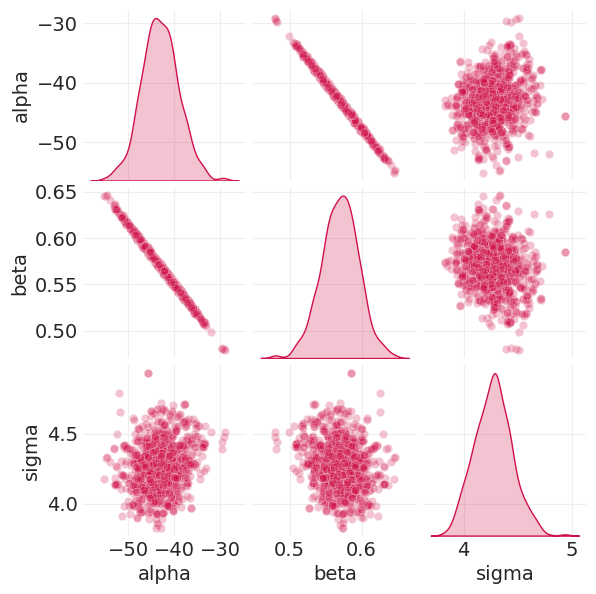

In [17]:
from seaborn import pairplot

pairplot(
    pd.DataFrame(
        {
            "alpha": howell_inference.posterior.sel(chain = 0)["alpha"],
            "beta": howell_inference.posterior.sel(chain = 0)["beta"],
            "sigma": howell_inference.posterior.sel(chain = 0)["sigma"]
        }
    ),
    diag_kind = "kde",
    plot_kws = {"alpha": .25},
    height = 2
);

##### Obey The Law:

- **parameters are not independent**
- **parameters cannot be interpreted in isolation**

Instead...**Push out posterior predictions**

Below, we again show:

- how the posterior is "made of lines" -- there are an infinite number of possible lines that can be drawn from the posterior
- confidence intervals can be established to communicate the uncertainty of the posterior's fit to the data

Sampling: [W_obs]


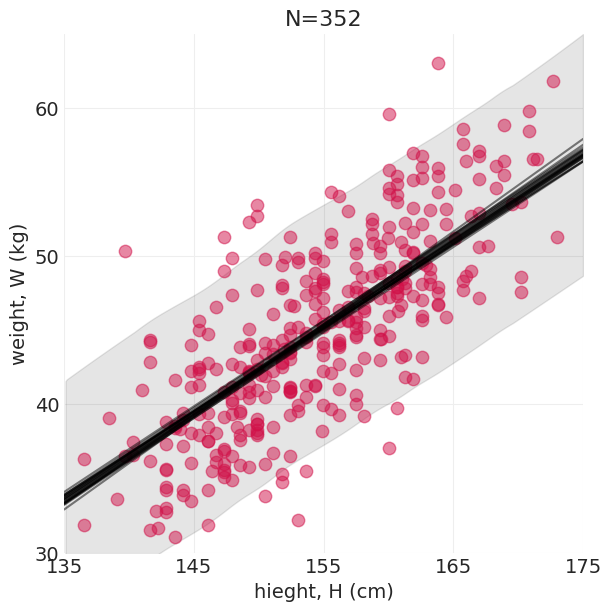

In [18]:
plt.subplots(figsize = (6, 6))
plt.scatter(ADULT_HOWELL.height.values, ADULT_HOWELL.weight.values, s = 80, zorder = 20, alpha = .5)
plot_linear_regression_posterior_predictive(
    howell_model, 
    howell_inference,
    min_height = 135,
    max_height = 175,
    min_weight = 30,
    max_weight = 65
)
plt.title(f"N={len(ADULT_HOWELL)}");